In [1]:
from scipy import io
from pathlib import Path

import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

I0000 00:00:1696005605.690448    9153 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, emissions.shape[0])
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)
    # lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, -lim, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([+1, 0, -1])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=range(state_probability_spread.shape[0]))
    plt.xlabel("time")

    plt.show()

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.show()

In [4]:
# Completely synthetic data - Only one strategy

targets = np.array([[15, 51, 87, 123, 159]*4*5]*50)
targets = rng.permuted(targets, axis=1)
# for x in targets: print(np.unique(x, return_counts=True))

# np random floats from -3 to 3 of shape 50, 100
jitters = rng.uniform(-3, 3, size=(50, 100))
observations = targets + jitters

observations.shape, targets.shape

((50, 100), (50, 100))

In [5]:
# target = 
# cursor = 

target = np.expand_dims(targets, axis=2)
cursor = np.expand_dims(observations, axis=2)
exp_bias = np.zeros((50, 100, 1))

train_emissions = cursor
train_inputs = np.concatenate((target, exp_bias), axis=2)

train_emissions.shape, train_inputs.shape

((50, 100, 1), (50, 100, 2))

In [6]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = LinearRegressionHMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, inputs=train_inputs, num_iters=10000, verbose=False)

    return lrhmm, fitted_params, lps

In [7]:
all_models, all_params, all_lps = [], [], []

# num_states = 4
input_dim = 2
emission_dim = 1

min_state = 2
max_state = 7

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)

Training: 2 states


/home/rudra/anaconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training: 3 states


/home/rudra/anaconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training: 4 states


/home/rudra/anaconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training: 5 states


/home/rudra/anaconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training: 6 states


/home/rudra/anaconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


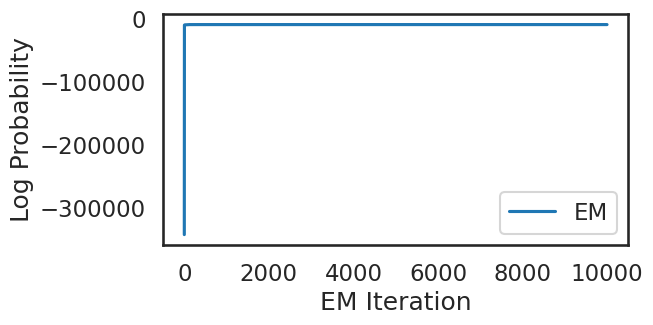

In [8]:
plot_lps(all_lps[4-2])

In [9]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model


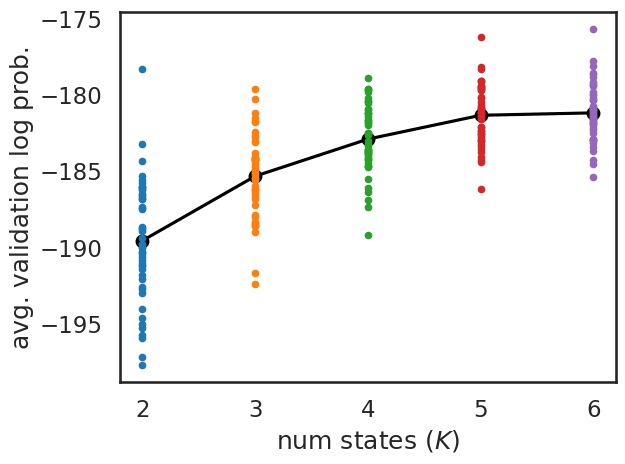

In [10]:
cross_train = cross_validate(all_models, all_params, train_emissions, train_inputs)
plot_validation(cross_valids=cross_train, show_var=True, max_states=max_state)

In [21]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

# for i in range(2):
#     inspect_sample(4-2, i)

In [12]:
fourth = all_models[4 - 2]
p_fourth = all_params[4 - 2]

In [13]:
# recovered_weights = fourth.observations.params

In [26]:
p_fourth.transitions.transition_matrix

Array([[0.11571752, 0.44824103, 0.33976293, 0.09627855],
       [0.11198967, 0.47835553, 0.32269922, 0.0869556 ],
       [0.11854365, 0.45745265, 0.3372402 , 0.08676349],
       [0.11521168, 0.48233563, 0.31528455, 0.08716812]], dtype=float32)

In [15]:
p_fourth.emissions.weights

Array([[[0.9998407, 0.       ]],

       [[1.0000079, 0.       ]],

       [[1.0002373, 0.       ]],

       [[0.9998664, 0.       ]]], dtype=float32)

In [16]:
p_fourth.emissions.biases

Array([[ 2.5976496 ],
       [ 0.89960873],
       [-1.4619883 ],
       [-2.647322  ]], dtype=float32)

In [17]:
p_fourth.emissions.covs

Array([[[0.06987763]],

       [[0.8619613 ]],

       [[0.48843572]],

       [[0.04078291]]], dtype=float32)

| state 1 | bias 2.597649574279785 | covs 0.06987763196229935 |
--------------------------------------------------
| state 2 | bias 0.8996087312698364 | covs 0.861961305141449 |
--------------------------------------------------
| state 3 | bias -1.4619883298873901 | covs 0.4884357154369354 |
--------------------------------------------------
| state 4 | bias -2.647321939468384 | covs 0.040782906115055084 |
--------------------------------------------------


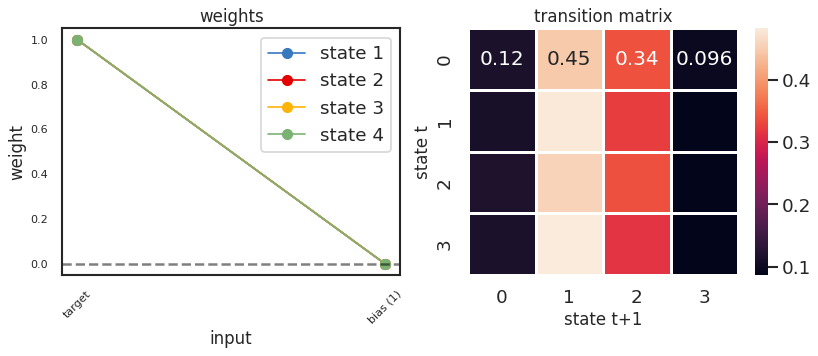

In [27]:
curr_states = 4

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1, 4*1), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
plt.xticks([0, 1], ['target', 'bias (1)'], fontsize=10, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white', )
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(4):
    print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

In [34]:
p_fourth.transitions.transition_matrix

Array([[0.11571752, 0.44824103, 0.33976293, 0.09627855],
       [0.11198967, 0.47835553, 0.32269922, 0.0869556 ],
       [0.11854365, 0.45745265, 0.3372402 , 0.08676349],
       [0.11521168, 0.48233563, 0.31528455, 0.08716812]], dtype=float32)

<Axes: >

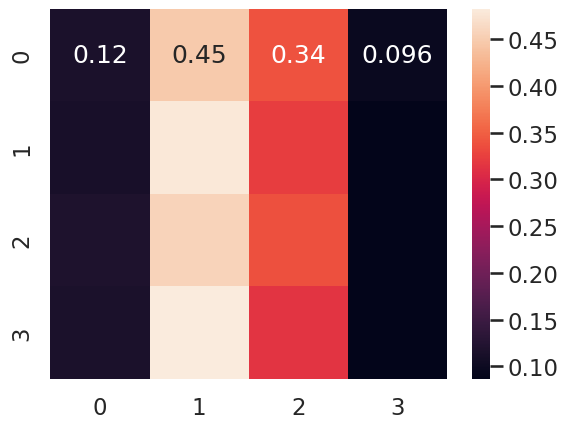

In [36]:
sns.heatmap(p_fourth.transitions.transition_matrix, annot=True,)

In [19]:
# --- identities ---
# Previous emission choice (n-1)
# (n-2)
# (n-3)

# --- n_repetitions ---
# count of repetitions in n-3 buffer

# Cumulative previous motor bias (low resolution angle [quadrants]) (n-1)

# divided or focused attention
# Expectation bias
# global internal bias

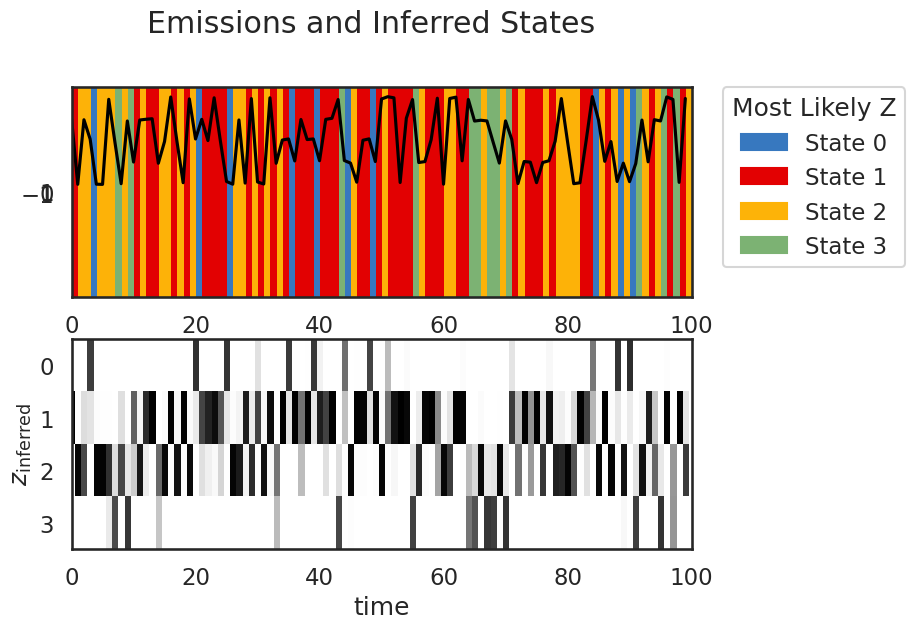

In [20]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(1): inspect_sample(4-2, i)